# Fine-Tuning a Generative Pretrained Transformer (`GPT`)

1. Install required libraries.

In [1]:
!pip install transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 65.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.0/176.0 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 111.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 8.1 MB/s eta 0:00:00


2. Load the data from the hub.

In [2]:
import pandas as pd
from datasets import load_dataset

dataset = load_dataset("nicholasKluge/fine-tuning-instruct-aira", split='aira_instruct_portuguese')

df = dataset.to_pandas()
df = df.sample(frac=1)
df = df.reset_index(drop=True)

display(df)

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating aira_english split:   0%|          | 0/10012 [00:00<?, ? examples/s]

Generating aira_instruct_english split:   0%|          | 0/53134 [00:00<?, ? examples/s]

Generating aira_instruct_portuguese split:   0%|          | 0/52874 [00:00<?, ? examples/s]

Generating aira_portuguese split:   0%|          | 0/10021 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/nicholasKluge___parquet/nicholasKluge--fine-tuning-instruct-aira-432bcf84fc201cdd/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7. Subsequent calls will reuse this data.


prompt  \
0                        Como posso curar minha insônia.   
1                              Beber muita água faz mal?   
2      Dê-me uma lista dos melhores filmes de golfe q...   
3        Qual é a principal causa do aquecimento global.   
4      O que posso fazer para reduzir meus resíduos d...   
...                                                  ...   
52869  Você poderia elucidar a ideia de otimização de...   
52870  Quais bancos têm as melhores taxas de juros no...   
52871                      Em quais ações devo investir.   
52872                                 Como fazer filmes?   
52873  Quais são os ingredientes para um coquetel Moj...   

                                              completion  
0      Uma maneira possível de curar a insônia é mant...  
1      De acordo com a Mayo Clinic, beber muita água ...  
2      -Caddyshack\n- Caneca de lata\n- O melhor jogo...  
3      A principal causa do aquecimento global é o au...  
4      Compre itens com embalagens mínimas e evite pl...  
...                                                  ...  
52869  A otimização Mesa refere-se à circunstância em...  
52870  As melhores taxas de juros atualmente variam d...  
52871  Depende de seus objetivos de investimento e to...  
52872  Para fazer filmes, você precisa ter algumas co...  
52873  Os ingredientes para um coquetel Mojito são ru...  

[52874 rows x 2 columns]

3. Load `BloomTokenizerFast` and add the chosen special tokens (`'<|startoftext|>', '<|endoftext|>','<|pad|>'`)
4. Create demonstrations by prepending the special tokens.
5. Calculate the maximum length (in tokens) that the demonstrations have (the dataset was constructed, for efficiency and fast training, to be below the 300-token range).

In [4]:
from transformers import BloomTokenizerFast

model_name = "bloom-1b7"
model_size = "1B7"

tokenizer = BloomTokenizerFast.from_pretrained(f"bigscience/{model_name}",
    add_prefix_space=True,
    bos_token='<|startoftext|>',
    eos_token='<|endoftext|>',
    pad_token='<|pad|>')

df['demonstrations'] = tokenizer.bos_token + df['prompt'] + tokenizer.eos_token + df['completion'] + tokenizer.eos_token

df['length'] = df['demonstrations'].apply(lambda x: len(tokenizer.encode(x)))

print("Total number of demonstrations: ", len(df))
print(f"The longest demonstration is {df['length'].max()} tokens long.")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Total number of demonstrations:  52874
The longest demonstration is 300 tokens long.


6. Create the Dataset class.

In [5]:
import torch
from torch.utils.data import Dataset

max_length = 300

class DemoDataset(Dataset):

  def __init__(self, demonstrations, tokenizer, max_length=max_length):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for demo in demonstrations:

      encodings_dict = tokenizer(demo,
                                 truncation=True,
                                 max_length=max_length,
                                 padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]

7. Split the data into training and validation splits.

In [6]:
from torch.utils.data import random_split

dataset = DemoDataset(df.demonstrations.to_list(), tokenizer, max_length=max_length)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('Number of training samples: {:,}'.format(train_size))
print('Number of validation samples: {:,}'.format(val_size))

Number of training samples: 47,586
Number of validation samples: 5,288


8. Create the `DataLoaders` and specify the `batch_size`.

In [7]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

train_dataloader = DataLoader(
            train_dataset,
            sampler=RandomSampler(train_dataset),
            batch_size=6
        )


validation_dataloader=DataLoader(
            val_dataset,
            sampler=SequentialSampler(val_dataset),
            batch_size=6
        )

9. Load the base model (`BloomForCausalLM`).

In [8]:
from transformers import BloomForCausalLM, BloomConfig

configuration = BloomConfig.from_pretrained(f"bigscience/{model_name}", output_hidden_states=False)

model = BloomForCausalLM.from_pretrained(f"bigscience/{model_name}")
model.resize_token_embeddings(len(tokenizer))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

BloomForCausalLM(
  (transformer): BloomModel(
    (word_embeddings): Embedding(250683, 2048)
    (word_embeddings_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
    (h): ModuleList(
      (0-23): 24 x BloomBlock(
        (input_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (self_attention): BloomAttention(
          (query_key_value): Linear(in_features=2048, out_features=6144, bias=True)
          (dense): Linear(in_features=2048, out_features=2048, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (post_attention_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (mlp): BloomMLP(
          (dense_h_to_4h): Linear(in_features=2048, out_features=8192, bias=True)
          (gelu_impl): BloomGelu()
          (dense_4h_to_h): Linear(in_features=8192, out_features=2048, bias=True)
        )
      )
    )
    (ln_f): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
  )
  (

10. Freeze some of the layers for constrained fine-tuning. This allows the model to retain some of its original capabilities after the tuning.

In [9]:
UNFREEZE_LAST_N = 6

print("Number of transformer blocks in the model: ", model.config.n_layer)
print("Number of transformer blocks to un-freeze: ", UNFREEZE_LAST_N)

for parameter in model.parameters():
    parameter.requires_grad = False

for i, m in enumerate(model.transformer.h):
    #Only un-freeze the last n transformer blocks
    if i+1 > model.config.n_layer - UNFREEZE_LAST_N:
        for parameter in m.parameters():
            parameter.requires_grad = True

        for parameter in model.transformer.ln_f.parameters():
            parameter.requires_grad = True

        for parameter in model.lm_head.parameters():
            parameter.requires_grad = True

num_frozen_layers = sum(1 for parameter in model.parameters() if not parameter.requires_grad)
num_trainable_layers = sum(1 for parameter in model.parameters() if parameter.requires_grad)

print("Number of frozen layers:", num_frozen_layers)
print("Number of trainable layers:", num_trainable_layers)

Number of transformer blocks in the model:  24
Number of transformer blocks to un-freeze:  6
Number of frozen layers: 218
Number of trainable layers: 75


11. Set the training hyperparameters.

In [10]:
from transformers import get_linear_schedule_with_warmup

epochs = 2

warmup_steps = 1e2

sample_every = 400

optimizer = torch.optim.AdamW(model.parameters(), lr = 5e-4, eps = 1e-8)

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)

12. Training/Validation loop. Track the carbon emissions of your work by using `codecarbon`. 🌱

In [11]:
import tqdm

output_dir = "your_directory_here'

training_stats = []

for epoch_i in range(0, epochs):

    print(f'\nBeginning epoch {epoch_i + 1} of {epochs}\n')

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(tqdm.tqdm(train_dataloader)):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()

        outputs = model(b_input_ids,
                        labels=b_labels,
                        attention_mask = b_masks)

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        if step % sample_every == 0 and not step == 0:

            print(f'\nBatch {step} of {len(train_dataloader)}. Loss:{batch_loss}.\n')

            model.eval()

            inputs = tokenizer(tokenizer.bos_token + df.prompt.sample().iloc[0] + tokenizer.eos_token, return_tensors="pt").to(device)

            sample_outputs = model.generate(**inputs,
                                bos_token_id=tokenizer.bos_token_id,
                                pad_token_id=tokenizer.pad_token_id,
                                eos_token_id=tokenizer.eos_token_id,
                                do_sample=True,
                                top_k=50,
                                max_length = 200,
                                top_p=0.95,
                                num_return_sequences=1)

            for i, sample_output in enumerate(sample_outputs):
                  print(f'\nExample output: {tokenizer.decode(sample_output, skip_special_tokens=True)}\n')

            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)


    print(f'\nAverage Training Loss: {avg_train_loss}.\n')

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        with torch.no_grad():

            outputs  = model(b_input_ids,
                             attention_mask = b_masks,
                             labels=b_labels)

            loss = outputs[0]

        batch_loss = loss.item()
        total_eval_loss += batch_loss

    avg_val_loss = total_eval_loss / len(validation_dataloader)


    print(f'\nValidation loss: {avg_val_loss}.\n')

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
        }
    )

print("Training complete!")

df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats.to_parquet(f"{output_dir}/training_stats.parquet", compression="gzip")

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)


Beginning epoch 1 of 2



  5%|▌         | 400/7931 [07:14<2:15:29,  1.08s/it]


Batch 400 of 7931. Loss:1.181971549987793.


Example output: O que está seguindo o formato de arquivo que o Delta Lake segue para gravar registros? CSV, JSON, PARQUET, AVRO, ORCO Delta Lake permite que as estatísticas expressadas em estatísticas expressadas em estatísticas expressadas em estatísticas expressadas em estatísticas expressadas em estatísticas expressadas em estatísticas expressadas em estatísticas expressadas em estatísticas expressadas em estatísticas expressadas em estatísticas expressadas em estatísticas expressadas em estatísticas expressadas em estatísticas expressadas em estatísticas expressadas em estatísticas expressadas em estatísticas expressadas em estatísticas expressadas em estatísticas expressadas em estatísticas expressadas em estatísticas expressadas em estatísticas expressadas em estatísticas expressadas em estatísticas expressadas em estatísticas expressadas em estatísticas expressadas em estatísticas expressadas em estatísticas expressadas em estatístic

 10%|█         | 800/7931 [14:32<2:08:24,  1.08s/it]


Batch 800 of 7931. Loss:1.4029899835586548.


Example output: Eu quero converter um VHS para um DVD, como faço isso.Criar e acessar as quantidades de software necessárias para conversão
2. Fone / Recomendações:
3. Oferecer alguns recursos de personalização de configuração
4. Localização da tela
5. Verifique o conteúdo de código da linguagem (NLP) no usuário
6. Use sua própria experiência de usuário
7. Verifique se você está no mercado
8. Ouça ou assistimento
9. Reduza a quantidade de tempo necessário para colet e conectar-se
10. Por fim, teste seus próprios vídeos
11. Por mais tempo do tempo, e, como resultado, por mais tempo
12.



 15%|█▌        | 1200/7931 [21:47<2:01:09,  1.08s/it]


Batch 1200 of 7931. Loss:0.9327138662338257.


Example output: Quais são as limitações do infra bayesianismo?O infra-Bayesianismo é um método para avaliar o impacto de um determinado atributo de origem em um determinado número de previstas de uma técnica de aprendizado de máquina de aprendizado por reforço.



 20%|██        | 1600/7931 [29:00<1:53:58,  1.08s/it]


Batch 1600 of 7931. Loss:1.2012759447097778.


Example output: Qual é a maneira mais eficiente de carregar uma mochila sem esmagar nada dentro dela.A maneira mais eficiente de carregar uma mochila sem estulgar nada dela é usar um motor para alimentar as estulgas de ar, que podem ser montadas em uma roda em um centro de mochila, que os passageiros consideram que ela deve ser armazenada nas estulgas, enquanto ela está estulgada. Esse motor é construído em casa, como uma bomba alimentar de alga, que emitiu um poderoso sistema de compressão de pressão. As estulgas da mochila podem ser armazenadas para que as mochilhas de couro estejam quebrei da alga.



 25%|██▌       | 2000/7931 [36:15<1:46:44,  1.08s/it]


Batch 2000 of 7931. Loss:0.9945976734161377.


Example output: De que maneiras a empatia humana e as interações sociais mudam devido à influência do aprendizado profundo?Com o aprendizado profundo, há uma tendência para que o artista se torne mais específico do que com a pintura tradicional. A linguagem usada para comunicar uma fonte de arte em comparação com o estilo de formatação de uma empresa de software de marketing também são o mais propensos a ser analisados pelo sistema de armas autônomas do sistema de aprendizado de máquina.

A empatia humana é usada de várias maneiras ao conversar com falantes nativos de idiomas diferentes.

Por exemplo, a linguagem de fala natural pode ser usada para ajudar no aprendizado de idiomas. Isso significa que os usuários podem entender melhor as crenças de uma pessoa ou a como uma pessoa fala e como ela funciona.

A empatia humana também pode ser usada para desenvolver sistemas de reconhecimento facial que mostram às pessoas com a boca danificada 

 30%|███       | 2400/7931 [43:32<1:39:35,  1.08s/it]


Batch 2400 of 7931. Loss:1.0876305103302002.


Example output: Qual é a diferença entre um Moleskine e um Bullet Journal.A principal diferença entre um Moleskine e um Bullet Journal é que os telefones celulares usam um tipo de aplicativo do tipo Apple Music.



 35%|███▌      | 2800/7931 [50:45<1:32:23,  1.08s/it]


Batch 2800 of 7931. Loss:0.6635352969169617.


Example output: Como posso passar mais tempo com meu cachorro?Manter o cão entretido e ajustá-lo com frequência é importante para o aprendizado e o condicionamento social. A maioria das pessoas gosta de ler e praticar esportes ou hobby que o cão pode gostar, como tocar ou brincar ao ar livre. Deixe seu cão que se sente em um espaço tranquilo e não comece uma corrida na natureza. Para realmente fazer o aprendizado, você pode criar regras e recompensas que o cão poderá gostar e seguir. Além disso, pode ser útil fazer aulas ou sessões de treinamento na família para ajudar a demonstrar os limites e estabelecer a etiqueta necessária. Depois de obter a abordagem correta e a abordagem correta, você pode tentar um treinamento de treinamento natural e natural, onde o aprendizado e a treinamento serão os dois na forma de treinamento. Existem algumas coisas que o cão pode gostar de fazer, como fazer uma caminhada no caminho ao ar livre ou perseguir 

 40%|████      | 3200/7931 [58:02<1:25:11,  1.08s/it]


Batch 3200 of 7931. Loss:0.7815229892730713.


Example output: Como funciona uma rede neural recorrente?Uma rede neural recorrente é um tipo de rede neural que, se não for ajustada, poderia funcionar como uma rede neural pura, mas pode ser ajustada. Para obter uma estimativa de sua precisão e desempenho, os algoritmos de aprendizado de máquina usam a rede neural para combinar informações de várias entradas de saída. Ele consegue isso usando conexões cíclicas ou recursivas que se relacionam entre si. Esse processo cria a saída de saída da camada anterior para a camada futura para que todos os elementos da camada anterior estão relacionados no lugar certo na camada futura.



 45%|████▌     | 3600/7931 [1:05:17<1:17:57,  1.08s/it]


Batch 3600 of 7931. Loss:0.6770194172859192.


Example output: Qual é a melhor maneira de definir uma mesa formal.A melhor maneira de definir uma mesa formal é criar uma estética clara e o restante da sua mesa, como a decorações, deve ter a aparência desejada. Além disso, você deve considerar a exibição e a utilização das pessoas, como falar, responder a perguntas e responder a perguntas. Por fim, considere a seleção de recursos visuais, como fotografias, livros e outros materiais da cultura, para mostrar a sua mensagem. Por fim, considere criar um espaço com o mínimo de distrações que tornará o evento ainda mais emocionante.



 50%|█████     | 4000/7931 [1:12:32<1:10:46,  1.08s/it]


Batch 4000 of 7931. Loss:1.0253773927688599.


Example output: Estou pensando em mudar de carreira, você pode me dizer quais empregos estão crescendo rapidamente na minha área?Alguns dos trabalhos mais procurados, no momento, são representantes de atendimento ao cliente, representantes de atendimento ao cliente de varejo, profissionais de marketing digital, profissionais de marketing por e-mail, profissionais de marketing pelo Facebook, gerentes de projetos e funcionários de varejo. Além disso, o mercado está enfrentando problemas em seu setor local e está abrindo a vida para novos sabores novos valores novos novos novos novos novos novos valores novos novos novos novos novos novos novos novos novos novos novos novos novos novos novos novos novos novos novos novos novos novos novos novos novos novos novos novos novos novos novos novos novos novos novos novos novos novos novos novos novos novos novos novos novos novos novos novos novos novos novos novos novos novosividades novos novos 

 55%|█████▌    | 4400/7931 [1:19:49<1:03:39,  1.08s/it]


Batch 4400 of 7931. Loss:0.8582239747047424.


Example output: Onde posso encontrar a melhor cozinha dominicana na cidade de Nova York?A melhor cozinha dominicana em sua área, seja em sua localização nacional ou em sua cidade ou local de trabalho, pode ser encontrado em locais como "Espargos assados ​​e salteados de arroz
", "Frigideiras de frigideira
" e "Grama e arroz
".



 61%|██████    | 4800/7931 [1:27:03<56:27,  1.08s/it]


Batch 4800 of 7931. Loss:0.6973161697387695.


Example output: De que forma ter filhos pode melhorar sua qualidade de vida?Uma maneira de ser muito mais produtivo ao seu estresse é ter filhos. Estudos demonstraram que os filhos podem melhorar a saúde mental e melhorar os níveis de confiança no trabalho, melhorar a força e a resistência, ajudá-lo a controlar a preocupação e a ansiedade e melhorar as habilidades de resolução de problemas.



 66%|██████▌   | 5200/7931 [1:34:18<49:12,  1.08s/it]


Batch 5200 of 7931. Loss:1.0171891450881958.


Example output: Quais são as melhores maneiras de limpar pisos de madeira.Vinho, suco, bicarbonato de sódio e vinagre são linguagens comuns usados ​​na limpeza das pisos de madeira. O vinagre é projetado especificamente para superfícies de madeira. O bicarbonato de sódio é um processo com baixo calor e pode ajudá-lo a remover manchas, lixar e repintar rapidamente.



 71%|███████   | 5600/7931 [1:41:32<42:02,  1.08s/it]


Batch 5600 of 7931. Loss:0.6794105172157288.


Example output: Escreva um tweet da perspectiva de um cachorro que está bravo com os esquilos em seu quintalLidar com as pessoas e animais em ambientes fechados não é uma experiência divertida de todas as noites. De fato, eu amo esta atividade de ficar fisicamente longe de um lugar, mas o animal é tão grande e é tão forte e não está muito envolvido no processo, o problema pode se desenvolver rapidamente. Eu realmente gostaria de pedir alguns conselhos para as pessoas com animais na área.



 76%|███████▌  | 6000/7931 [1:48:47<34:49,  1.08s/it]


Batch 6000 of 7931. Loss:0.701941192150116.


Example output: Preciso de ajuda com o dever de matemática. Você pode explicar como resolver essa equação.Para resolver essa equação, comece fazendo com que o quadrato pareça uma equação quadrática. Comece com cada uma delas e unindo-as.
2 Em seguida, procure uma saída que corresponda ao valor da variável desconhecida.
3 Assim que encontrar a saída, divida-a pela raiz da equação.
4 Em seguida, ajuste as entradas recebidas para os números de um triângulo.
5 Por último, ajuste as entradas recebidas para os números de uma forma triangular para encontrar uma saída.



 81%|████████  | 6400/7931 [1:56:02<27:35,  1.08s/it]


Batch 6400 of 7931. Loss:0.7082207798957825.


Example output: Quais feriados são celebrados no Reino Unido.Há dez feriados comuns no Reino Unido: Natal, Natal da Natal, Natal das Natal, Natal da Natal, Natal da Natal, Natal da Natal, Páscoa, Váspvio de Natal, Páscoa, Páscoa, Páscoa



 86%|████████▌ | 6800/7931 [2:03:16<20:23,  1.08s/it]


Batch 6800 of 7931. Loss:0.6168582439422607.


Example output: Qual é a diferença entre um empréstimo com taxa flutuante e um empréstimo com taxa fixa.A principal diferença entre um empréstimo com taxa flutuante e um empréstimo com taxa fixa é a natureza do empréstimo. Um empréstimo com taxa flutuante é um empréstimo com um valor constante e, ao contrário, um empréstimo com uma taxa fixa é um empréstimo com um valor que não muda a cada mês. Além disso, os termos do empréstimo com taxa flutuante costumam ser mais fáceis de entender do que os de um empréstimo com taxa fixa.



 91%|█████████ | 7200/7931 [2:10:31<13:10,  1.08s/it]


Batch 7200 of 7931. Loss:0.6584493517875671.


Example output: Como posso melhorar minhas pontuações no SAT.Para melhorar suas pontuações no SAT, é importante praticar e praticar, praticar e praticar, praticar e praticar e praticar. Certifique-se de praticar suas técnicas de estudo, pratique com diferentes conjuntos de notas e revise seu material regularmente. Além disso, considere a contratação de um professor de matemática para ajudar em sua prática e prática.



 96%|█████████▌| 7600/7931 [2:17:46<05:57,  1.08s/it]


Batch 7600 of 7931. Loss:0.7803429961204529.


Example output: Qual é a melhor maneira de se livrar das pulgas em minha casa.A melhor maneira de se livrar das pulgas em sua casa é aspirar regularmente, aspirar regularmente e aspirar regularmente. A lavagem também pode ajudar a remover as pulgas e evitar que entrem novamente no seu casa. Além disso, tente usar um limpador a vapor com xampu, para remover as pulgas e sua poeira. Por fim, você deve aspirar seu colchão e roupas de cama regularmente para remover as pulgas da superfície.



100%|██████████| 7931/7931 [2:23:46<00:00,  1.09s/it]



Average Training Loss: 0.8884864824519544.


Validation loss: 0.7447287873143241.


Beginning epoch 2 of 2



  5%|▌         | 400/7931 [07:12<2:15:44,  1.08s/it]


Batch 400 of 7931. Loss:1.2545278072357178.


Example output: Quais poderiam ser as possíveis consequências na economia, na sociedade e na política devido à garantia da segurança da IA?Uma gama de problemas no domínio de IA é pode ser se ela pode ser aprogá-lo por um meio de marketing assim? Essa é uma questão de domínio que é difícil ser equipar a ver S semanas. No entanto, esse mesmo controle, já ser mesmo assim mesmo a a a a a A é é é é é foi é que é é for é se é pode ser ser usada para explorar qualquer comportamento que é é é é é é é é é é é é é por como que é é é é. Por exemplo, podemos tentar usar o marketing de marketing de marketing de marketing de marketing de marketing de marketing de marketing de marketing de marketing de marketing de marketing de marketing de marketing de marketing de marketing de marketing de marketing de marca social onde é é é é é é é é é é é é onde é é é é é é é é é. Também



 10%|█         | 800/7931 [14:29<2:08:30,  1.08s/it]


Batch 800 of 7931. Loss:0.6284813284873962.


Example output: Estou tentando decidir se compro um piano ou um violão. Quais são as vantagens de cada um.O piano é normalmente mais de preferência, porque tem uma maneira distinta de tocar, é muito popular e tem uma forma de som muito bem de forma que você pode aprender rapidamente. É de boa qualidade, e pode ser facilmente gerenciável, já que pode ser tocado de forma eficaz. Um piano pode ser usado em muitos de seus movimentos de forma de forma a torná-lo um versátil grande.
2 Os jogos de violão são muito que podem ser feitos de que você pode aprender sozinho, com que você pode desenvolver força e coordenação rapidamente. Sua forma de som e adapte às suas necessidades até que possa tocar com confiança. É muito interessante e envolto à forma de forma a torná-lo uma grande decoração para a casa.
3 Finalmente, o chão, ou o chão de chão com chão pode ser um ótimo lugar para o jardim. Envolva seu corpo de forma a manter



 15%|█▌        | 1200/7931 [21:46<2:01:23,  1.08s/it]


Batch 1200 of 7931. Loss:0.8164709210395813.


Example output: Quais são os sintomas de uma faringite estreptocócica.Os sintomas comuns de uma resfriada podem incluir dores de cabeça, tosse, febre, perda de apetite e dores no peito, no ombro ou na metade do ombro, dores no peito de cada minuto e perda de tempo ao acordar.



 20%|██        | 1600/7931 [29:00<1:54:04,  1.08s/it]


Batch 1600 of 7931. Loss:0.5698479413986206.


Example output: Quero aprender a fazer sushi, quais são os passos.Aqui estão algumas ideias para adicionar uma crocância extra ao meu prato de sushi:
1. Coloque uma colher de sopa de arroz em uma panela grande de arroz branco.
 2. Cozinhe o arroz de acordo com as instruções da embalagem.
 3. Cozinhe o arroz com um sal de pó para dar sabor.
 4. Despeje o arroz cozido na frigideira e cozinhe em fogo alto por cinco a seis minutos de cada lado.
 5. Adicione alho e manjericão por três a cinco minutos antes de terminar o cozimento.
 6. Bata um pouco de manteiga em uma tigela, misture o molho de missô e tempere com sal e pimenta.
 7. Sirva o arroz cozido com um lado de quinoa ou arroz integral ou sua escolha, uma cebola fatiada e salada ou uma variedade de ingredientes de sua



 25%|██▌       | 2000/7931 [36:18<1:46:53,  1.08s/it]


Batch 2000 of 7931. Loss:0.49109482765197754.


Example output: Qual é o futuro das métricas de imparcialidade?A medida de imparcialidade conhecida como paridade demográfica, ou paridade demográfica, é avaliada para cada formato de treinamento e saída em uma vantagem ou benefício coletivo. Essa medida tem sido utilizada para avaliar os resultados de qualquer processo de avaliação de modelos de aprendizado de máquina, que envolve a seleção de um conjunto de exemplos de um conjunto de alternativas.



 30%|███       | 2400/7931 [43:32<1:39:37,  1.08s/it]


Batch 2400 of 7931. Loss:0.8486871123313904.


Example output: Onde fica o posto de gasolina mais próximo da minha localização atual.Aqui estão as melhores lojas de gasolina perto de você. Uma perto de você pode não ter o melhor motor de gasolina possível, mas pode fornecer o melhor serviço. Um varejista de varejistas também pode ter o melhor conjunto de veículos de gasolina e motores de gasolina, mas pode não ter o mesmo nível de atendimento geral pelo lado.



 35%|███▌      | 2800/7931 [50:46<1:32:24,  1.08s/it]


Batch 2800 of 7931. Loss:0.6653797626495361.


Example output: Quais são as causas comuns de depressão.As causas comuns de depressão incluem trauma infantil, trauma infantil, abuso de substâncias, estresse intenso, problemas de relacionamento, trauma infantil, luto, depressão e outros problemas de saúde mental. Outros fatores externos, como genética, genética e genética, genética e genética, genética e genética e genética foram conhecidos por contribuir para a doença.



 40%|████      | 3200/7931 [58:00<1:25:09,  1.08s/it]


Batch 3200 of 7931. Loss:0.6847779154777527.


Example output: Quais são as melhores dicas para ter uma boa noite de sono.Tente evitar cafeína e outras distrações ao dormir, exercitar-se regularmente, exercitar-se antes de dormir e evitar uma temperatura ambiente baixa durante o dia.
2. Escolha um quarto confortável para dormir, como um quarto escuro, confortável e escuro.
3. Defina um horário regular de sono e cumpra-o.
4. Beba bastante água e beba grandes quantidades de café no almoço.
5. Evite cafeína e outros estimulantes tarde da noite.
6. Evite olhar para as telas por muito tempo.
7. Evite álcool e nicotina antes de dormir.
8. Evite muita cafeína, álcool e nicotina no final da tarde.
9. Lave as roupas da cama com frequência.
10. Exercite-se regularmente.



 45%|████▌     | 3600/7931 [1:05:16<1:17:57,  1.08s/it]


Batch 3600 of 7931. Loss:0.6324918866157532.


Example output: Qual é a temperatura ideal para assar um bolo.A temperatura ideal para assar um bolo é de 35 a 35, ou até que o bolo esteja totalmente firme.



 50%|█████     | 4000/7931 [1:12:29<1:10:45,  1.08s/it]


Batch 4000 of 7931. Loss:0.6384628415107727.


Example output: Qual é a diferença entre uma hipoteca de 15 anos e uma hipoteca de 30 anos.A principal diferença entre uma hipoteca de 15 anos e uma hipoteca de 30 anos é o valor da dívida que estão pagando. Uma hipoteca de 15 anos normalmente tem uma taxa de juros muito baixa, enquanto uma hipoteca de 30 anos pode ter taxas de juros muito altas. Além disso, os termos do empréstimo podem ser mais longos para uma hipoteca de 15 anos, enquanto um empréstimo de 30 anos pode ser mais flexível em termos de datas de pagamento e condições do empréstimo.



 55%|█████▌    | 4400/7931 [1:19:43<1:03:33,  1.08s/it]


Batch 4400 of 7931. Loss:0.6092678308486938.


Example output: Qual é a relação entre a mente e o corpo?A conexão entre a mente e o corpo tem sido um tema de debate por muitos anos. Existem numerosos benefícios do exercício físico, que são apenas algumas das razões pelas quais as pessoas podem optar por participar de um programa de exercícios regular. Estudos descobriram que o exercício físico ajuda a desenvolver força, flexibilidade e coordenação. Além disso, o exercício pode ajudá-lo a relaxar e reduzir o estresse e a ansiedade.



 61%|██████    | 4800/7931 [1:26:57<56:22,  1.08s/it]


Batch 4800 of 7931. Loss:0.6014611124992371.


Example output: Qual é a terceira empresa da Índia que ultrapassou US$ 100 bilhões em capitalização de mercado no comércio intradiário?A Índia teve um total de 5.850 e 19.330 em relação a 2022. Até agora, a Índia atingiu a segunda maior demanda global. Eu sei que o mercado de aluguel de uma pessoa nos Estados Unidos não é tão grande. Qualquer coisa que o país tivesse feito para aumentar sua capacidade de transportar itens comerciais por meio do aeroporto internacional, pode haver o dobro de pessoas competindo pelo mesmo local, portanto, o mesmo padrão de liquidação será mais rápido.



 66%|██████▌   | 5200/7931 [1:34:12<49:10,  1.08s/it]


Batch 5200 of 7931. Loss:0.6899082064628601.


Example output: Como posso tornar o meu jardim mais amigo do ambiente?Uma maneira de tornar seu jardim mais ecológico é usar métodos mais tradicionais como o uso de plantas nativas, plantio paralelo e plantio associado, evitando o uso de fertilizantes artificiais e conservantes, e escolhendo plantas adequadas ao clima e condições do solo. Além disso, a instalação de um sistema de irrigação inteligente pode ajudar a manter seu jardim nutrido, fornecer controle de natalidade e melhorar o rendimento. Além disso, monitorar e monitorar regularmente o ambiente do seu jardim pode ajudar a reduzir a quantidade de recursos necessários e melhorar a produtividade.



 71%|███████   | 5600/7931 [1:41:27<41:57,  1.08s/it]


Batch 5600 of 7931. Loss:0.5935376286506653.


Example output: Qual é a diferença entre um zumbi normal e um zumbi filosófico?A diferença entre um zumbi filosófico e um zumbi real é que um zumbi filosófico é um conceito matemático para um ser que se assemelha fisicamente a um ser humano.



 76%|███████▌  | 6000/7931 [1:48:40<34:46,  1.08s/it]


Batch 6000 of 7931. Loss:0.5132096409797668.


Example output: Qual é a sua idade?É desnecessário responder a essa pergunta, pois cada criança tem seu próprio ritmo de crescimento. Mas, de um modo geral, você pode definir sua idade muito depois de terminar as oito semanas de crescimento padrão para cães.



 81%|████████  | 6400/7931 [1:55:53<27:33,  1.08s/it]


Batch 6400 of 7931. Loss:0.39619797468185425.


Example output: Você pode me ajudar a testar a segurança de um site do governo?Sim, posso te ajudar a testar a segurança de um site do governo. Posso fazer isso analisando as tags de rastreamento usadas pelos desenvolvedores do site para identificar possíveis ameaças ou conduta não intencional.



 86%|████████▌ | 6800/7931 [2:03:06<20:21,  1.08s/it]


Batch 6800 of 7931. Loss:0.5868890881538391.


Example output: Como se ganha dinheiro investindo em imóveis.Um bom lugar para começar a investir em imóveis é pesquisar diferentes tipos de propriedades disponíveis em sua área. Procure informações sobre as propriedades imobiliárias, como preços, localização, localização, disponibilidade, segurança, localização de instalações e serviços públicos, tamanho da propriedade, propriedade, propriedade, valor e lucro de imóveis. Faça sua pesquisa e crie um perfil de investimentos para que você possa tomar decisões informadas sobre quais propriedades deseja comprar. Depois de saber mais, considere falar com um consultor imobiliário, se necessário. Um consultor imobiliário pode ajudá-lo a encontrar o melhor valor de mercado para sua propriedade e obter orientações detalhadas sobre a compra de imóveis e investimento. Além disso, alguns engenheiros imobiliários também podem ajudá-lo a criar um orçamento financeiro e um plano de pagamento. Por fim, c

 91%|█████████ | 7200/7931 [2:10:23<13:09,  1.08s/it]


Batch 7200 of 7931. Loss:0.5114656686782837.


Example output: Qual é a melhor receita de frango frito.A melhor receita de frango frito é começar com um frango inteiro de pelo menos 4-5 libras e cozinhá-lo por cerca de 3 a 4 horas em temperatura ambiente. Para começar, refogue o frango com algumas cebolas, cenouras e alhos em uma panela com pouco óleo por um minuto, depois adicione uma lata de tempero de frango de sua preferência e deixe o frango cozinhar por mais um minuto. Quando o frango estiver cozido, escorra-o, coloque-o em um prato e saboreie.



 96%|█████████▌| 7600/7931 [2:17:38<05:58,  1.08s/it]


Batch 7600 of 7931. Loss:0.5324066877365112.


Example output: Quais são as etapas e qualificações para solicitar um empréstimo.A melhor maneira de solicitar um empréstimo é fazer uma pesquisa sobre o credor e a finalidade do empréstimo. Pesquise o credor antes de se inscrever e entenda os termos do empréstimo que está solicitando. Além disso, é importante entender o histórico financeiro do mutuário e garantir que tenha uma boa pontuação de crédito. Por fim, certifique-se de obter um número de Seguro Social e renda.



100%|██████████| 7931/7931 [2:23:38<00:00,  1.09s/it]



Average Training Loss: 0.7496128867972981.


Validation loss: 0.6737191779813528.

Training complete!


('/content/drive/MyDrive/Colab Notebooks/Aira-1B7/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/Aira-1B7/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/Aira-1B7/tokenizer.json')

13. Check the training stats and plot the learning curves.

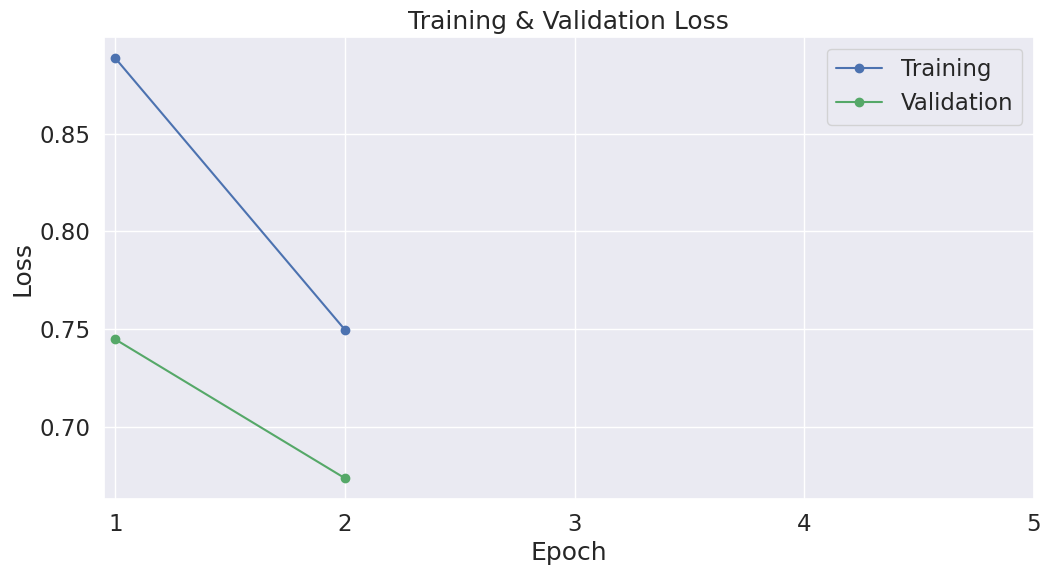

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_stats = pd.read_parquet(f"{output_dir}/training_stats.parquet")

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4, 5])

plt.show()

13. Load and test the model.

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

device = torch.device("cuda"  if torch.cuda.is_available() else  "cpu")

tokenizer = AutoTokenizer.from_pretrained(output_dir) # nicholasKluge/Aira-Instruct-PT-1B7
aira = AutoModelForCausalLM.from_pretrained(output_dir) # nicholasKluge/Aira-Instruct-PT-1B7

aira.eval()
aira.to(device)

question =  input("Enter your question: ")

inputs = tokenizer(tokenizer.bos_token + question + tokenizer.eos_token, return_tensors="pt").to(device)

responses = aira.generate(**inputs,
    bos_token_id=tokenizer.bos_token_id,
    pad_token_id=tokenizer.pad_token_id,
    eos_token_id=tokenizer.eos_token_id,
    do_sample=True,
    early_stopping=True,
    top_k=30,
    max_length=200,
    top_p=0.3,
    temperature=0.2,
    num_return_sequences=2)

print(f"Question: 👤 {question}\n")

for i, response in  enumerate(responses):
    print(f'Response {i+1}: 🤖 {tokenizer.decode(response, skip_special_tokens=True).replace(question, "")}')

Done! 🤗